In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

1단계: 현재 가지고 있는 3년 간의 실적 데이터 중 공정머신 0401로 생산되는 품목들과 관련하여 실제 작업 일수와 수량 데이터 분석

In [2]:
# 데이터 불러오기
# 실제 엑셀 시트에서 sheet_3에 다음과 같이 2개의 데이터만 볼 수 있도록 사전 작업 진행
df = pd.read_excel("NC공정 생산이력.xlsx", sheet_name = 2)
df

,Working,Quantity
0,2018-01-04,40
1,2018-01-10,4
2,2018-01-10,4
3,2018-01-31,5
4,2018-02-01,6
...,...,...
511,2020-11-18,19
512,2020-11-18,21
513,2020-11-02,32
514,2020-12-08,2


In [4]:
df.columns

Index(['Working', 'Quantity'], dtype='object')

In [5]:
df.tail()

,Working,Quantity
511,2020-11-18,19
512,2020-11-18,21
513,2020-11-02,32
514,2020-12-08,2
515,2020-12-08,2


In [6]:
# to_datetime의 경우, string 타입의 시간을 Timestamp형으로 변경해주는 함수

df['Working'] = pd.to_datetime(df['Working'])

In [7]:
df['Working']

0     2018-01-04
1     2018-01-10
2     2018-01-10
3     2018-01-31
4     2018-02-01
         ...    
511   2020-11-18
512   2020-11-18
513   2020-11-02
514   2020-12-08
515   2020-12-08
Name: Working, Length: 516, dtype: datetime64[ns]

In [8]:
# 하기와 같이 set_index를 사용하여 Wokring(작업일자)를 기준으로 데이터 정리
df.set_index('Working',inplace=True)

In [9]:
df.index

DatetimeIndex(['2018-01-04', '2018-01-10', '2018-01-10', '2018-01-31',
               '2018-02-01', '2018-02-02', '2018-02-05', '2018-02-05',
               '2018-02-06', '2018-02-06',
               ...
               '2020-11-16', '2020-11-17', '2020-12-08', '2020-11-17',
               '2020-11-17', '2020-11-18', '2020-11-18', '2020-11-02',
               '2020-12-08', '2020-12-08'],
              dtype='datetime64[ns]', name='Working', length=516, freq=None)

In [10]:
# 작업 일자를 기준으로 수량의 개수, 평균, 표준편차, 최소값, 4분위, 최대값 확인
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,516.0,18.858527,13.182415,0.0,6.0,17.0,31.0,80.0


2단계: 이전 단계에서 정리했던 데이터를 바탕으로 시각화작업하기
해당 데이터에서 일자로도 볼 수 있지만, 그래프가 복잡해질 수도 있어 여기서는 달 기준으로 4개월 간격으로 표시

<AxesSubplot:xlabel='Working'>

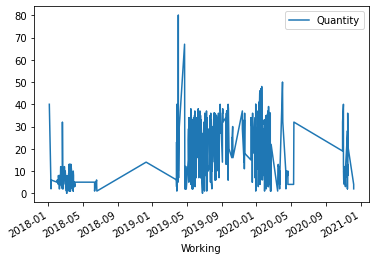

In [12]:
df.plot()

In [13]:
time_series = df['Quantity']

In [14]:
# 해당 기능을 사용하여 각 일자에 해당 장비에서 몇 개 생산되었는지 확인
time_series

Working
2018-01-04    40
2018-01-10     4
2018-01-10     4
2018-01-31     5
2018-02-01     6
              ..
2020-11-18    19
2020-11-18    21
2020-11-02    32
2020-12-08     2
2020-12-08     2
Name: Quantity, Length: 516, dtype: int64

In [15]:
type(time_series)

pandas.core.series.Series

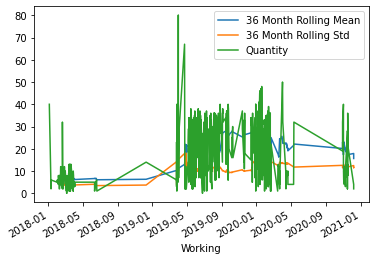

In [16]:
# 현재 데이터의 경우, 대략 3년 정도의 데이터를 가지고 있기 때문에 여기에서 또한 36개월을 반영
time_series.rolling(36).mean().plot(label='36 Month Rolling Mean')
time_series.rolling(36).std().plot(label='36 Month Rolling Std')
time_series.plot()
plt.legend()

- 시계열 데이터는 보통 stationary의 특성을 가지고 있지 않다. 
- 시간에 따라 통계적 특성이 변하기 때문이다. 그렇기에 일단 알기 쉽게 stationary로 변경할 필요가 있다. 
- 여기서는 우선 전통적인 ARIMA를 통해 시계열을 예측
- ARIMA 모형은 과거의 데이터를 사용하는 것 뿐만 아니라 추세를 반영

In [1]:
# Augmented Dickey-Fuller test( unit root test)를 통해 검증
# 검증 조건 ( p-value : 5% 이내면 reject으로 대체가설 선택됨)

from statsmodels.tsa.stattools import adfuller

- Augmented Dicky-Fuller Test (검정통계량)
    - 검정통계량이 Critical Value보다 작으면 Stationary한 시계열 데이터
    - 또는 p-value가 설정한 신뢰 수준의 값 (ex. 0.05)보다 작으면 stationary한 시계열 데이터
    
- 하여 함수에서 0.05로 p-value를 기준으로 한 뒤, 그 이하이면  stationary로 표현하기 때문에 처음에는 stationary한 값이 나올 때가지 반복

In [22]:
result = adfuller(df['Quantity'])

In [23]:
def adf_check(time_series):
    
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistics','p-value','# of lags','Num of Observations']
    
    for value,label in zip(result,labels):
        print(label+ " : "+str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("reject null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and is non-stationary")

In [24]:
# 현재의 Quantity를 가지고 실행하였을 때, non-stationary
adf_check(df['Quantity'])

Augmented Dicky-Fuller Test
ADF Test Statistics : -2.590309789066895
p-value : 0.09501662188734289
# of lags : 16
Num of Observations : 499
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


- 우선 상기에서 원래의 Quantity를 가지고 하였을 때, non-stationary로 판별
- 하여 원래의 데이터에서 과거 데이터를 참고하여 추세를 반영하기 위하여 한 칸씩 값이 밀린 결과값을 빼 추세를 반영
- 한 칸씩 값이 밀렸다는 의미는, 2018년 1월 4일의 40개가 1월 10일에 들어가고, 1월 10일에 들어있던 값이 그 뒤의 날짜로 이동했다는 의미

In [25]:
df['First Difference'] = df['Quantity'] - df['Quantity'].shift(1) # 이건 값들이 하나씩 뒤로 넘어감

<AxesSubplot:xlabel='Working'>

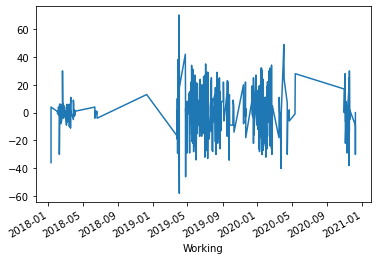

In [26]:
df['First Difference'].plot()

In [27]:
adf_check(df['First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistics : -9.741788834895099
p-value : 8.457574917500374e-17
# of lags : 15
Num of Observations : 499
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


- 상기의 결과를 보면 stationary한 결과값이 나왔기 때문에 해당 작업은 여기서 종료
- 대신, 계절성을 반영하기 위하여 seasonal difference를 적용
- 계절성을 반영하기 위해 1년을 기준으로 하여 값이 12개를 기준으로 뒤로 밀리게 된다. 
- 그래프로 보면 전에 있던 그래프와 차이가 발생한 것을 볼 수 있다. 

In [30]:
df['Seasonal Difference'] = df['Quantity'] - df['Quantity'].shift(12)

<AxesSubplot:xlabel='Working'>

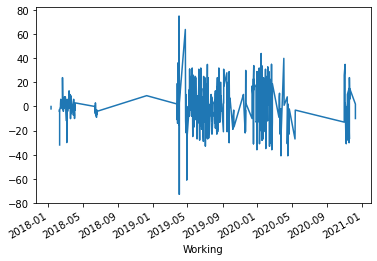

In [31]:
df['Seasonal Difference'].plot()

In [32]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistics : -5.557916422488652
p-value : 1.5655802303877128e-06
# of lags : 16
Num of Observations : 487
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


In [33]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)

- 상기의 경우, 결과값이 stationary가 나왔지만, 계절성을 반영하지 않은 것을 2번 하였기 때문에 여기서도 그냥 같이 2번 진행함

<AxesSubplot:xlabel='Working'>

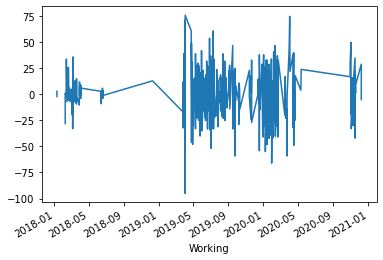

In [34]:
df['Seasonal First Difference'].plot()

In [35]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistics : -11.640040636169912
p-value : 2.1579409513722888e-21
# of lags : 15
Num of Observations : 487
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


3단계: ACF와 PACF plot 반영

- ARIMA의 경우, 자기상관성을 가지고 있기 때문에 ACF 값을 확인해 볼 필요가 있다. 
- 하기의 그래프를 확인해보면 처음과 두 번째의 경우가, 다른 시차들보다 높은 결과를 가지게 된다.
- 만약 계절성이 잘 반영이 되었다면 1년에서 4개월 각 분기마다 패턴이 드러나야 하지만, 그렇지 않고 있다. 
- 그렇다면 해당 생산의 경우, 계절성이 없을 수도 있겠구나 추측해 볼 수 있다. 

In [36]:
# 3단계 : ACF와 PACF plot 반영

In [37]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

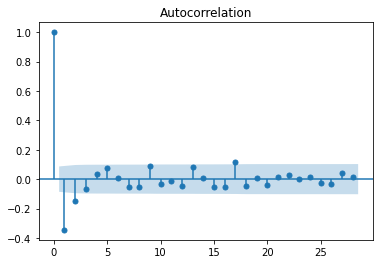

In [38]:
fig_first = plot_acf(df['First Difference'].dropna())

- 현재 여기서 파란색으로 색칠판 부분은 백색 잡음을 나타낸다고 볼 수 있다. 
- 백색잡음이란 자기상관이 없는 시계열을 나타낼 때 부르는 용어
- 해당 범위를 벗어나는 데이터의 5% 이상이 해당 경게를 벗어난다면 백색 잡음이 아니라는 말
- 하지만 현재 데이터는 처음 부분을 제외하고는 백색 잡음이 아니라는 것을 볼 수 있다. 

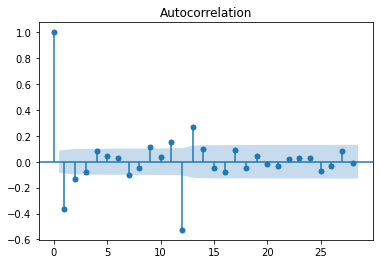

In [39]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

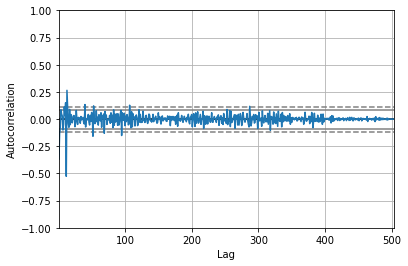

In [42]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

- 하지만 하기 그래프 (즉 계절성 2번째를 반영했던 값)들의 경우, 백색 잡음을 나타낸다. 
- 잡음을 I.I.D를 따르는 확률변수로 과정을 정상화과정이라고 한다.  

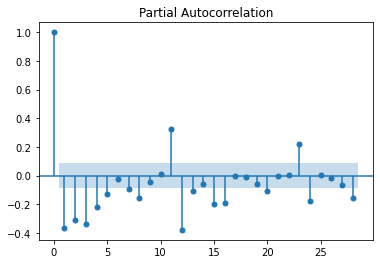

In [43]:
result = plot_pacf(df['Seasonal First Difference'].dropna())

If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag.If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

This will allow us to decide what actual values of p,d and q to provide for our ARIMA model.

p --> # of lag observations

d --> # of times that raw observations are differenced


q --> the size of the moving average window, also called the order of moving average

Now we will plot a pacf. In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

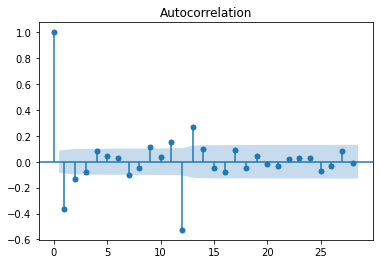

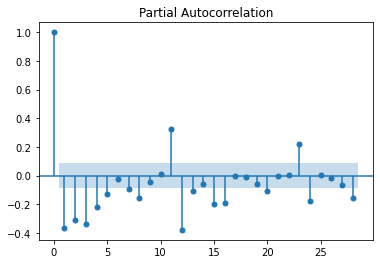

In [45]:
plot_acf(df['Seasonal First Difference'].dropna());
plot_pacf(df['Seasonal First Difference'].dropna());

4단계: ARIMA 분석

In [47]:
from statsmodels.tsa.arima_model import ARIMA

In [48]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  .. deprecated:: 0.12
 |     Use statsmodels.tsa.arima.model.ARIMA instead
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M',

In [49]:
model = sm.tsa.statespace.SARIMAX(df['Quantity'],order=(0,1,0),seasonal_order=(1,1,1,12))

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignor

In [50]:
results = model.fit()

- 하기 데이터를 볼 때에는 우선 Covariance type을 간단하게 확인
- p값이 유의수준(0.05)보다 작으면 통계적으로 유의하고, 반대인 경우에는 통계적으로 유의하지 않다. 
- 여기서는 통계적으로 유의미하다는 것을 호가인해 볼 수 있다. 

In [51]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             Quantity   No. Observations:                  516
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2090.308
Date:                              Fri, 04 Jun 2021   AIC                           4186.616
Time:                                      04:30:39   BIC                           4199.277
Sample:                                           0   HQIC                          4191.583
                                              - 516                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0460      0.046     -1.005      0.315      -0.136       0.044
ma.S.L12      -0.99

<AxesSubplot:xlabel='Working'>

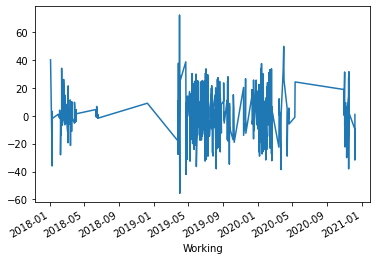

In [52]:
results.resid.plot()

<AxesSubplot:ylabel='Density'>

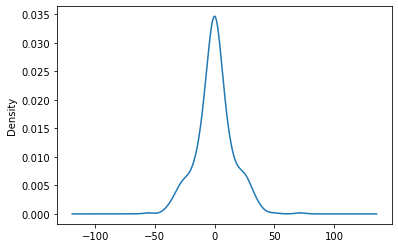

In [53]:
results.resid.plot(kind='kde')

- 하기 그래프를 통해 실제 값과 과거 시계열 데이트의 추세를 반영한 Forecast와 비교
- 거의 유사하며 2020년 5월부터 2021.01 전까지의 데이터에서 많은 차이가 발생한 것을 제외하고는 대부분 예측이 잘되는 것으로 추측
- 실제 order와 forecast를 비교한 값은 아래에 표시

<AxesSubplot:xlabel='Working'>

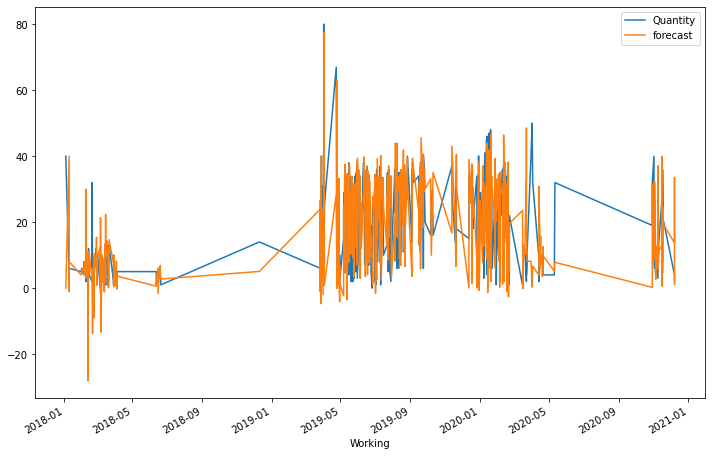

In [57]:
df['forecast'] = results.predict(start = None, end = None)
df[['Quantity','forecast']].plot(figsize=(12,8))

In [58]:
df.tail()

,Quantity,First Difference,Seasonal Difference,Seasonal First Difference,forecast
Working,,,,,
2020-11-18,19,-5.0,6.0,1.0,24.451872
2020-11-18,21,2.0,15.0,9.0,19.434525
2020-11-02,32,11.0,-4.0,-19.0,19.236068
2020-12-08,2,-30.0,-5.0,-1.0,33.564528
2020-12-08,2,0.0,-10.0,-5.0,1.096406


In [59]:
len(df)

516

하기의 경우, 분석한 과거 추세를 바탕으로 미래의 24개월(2년치) 수량을 예측하고자 하는 것
- 처음에는 모든 값에 NaN이 들어가 있지만, 예측을 통해 해당 값을 채울 예정
- 현재는 정확하게 수량이 반영이 되지 않았지만, 코드를 수정하여 Forecast 값을 확인할 예정

In [60]:
from pandas.tseries.offsets import DateOffset

In [61]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]

In [62]:
future_dates

[Timestamp('2021-01-08 00:00:00'),
 Timestamp('2021-02-08 00:00:00'),
 Timestamp('2021-03-08 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-05-08 00:00:00'),
 Timestamp('2021-06-08 00:00:00'),
 Timestamp('2021-07-08 00:00:00'),
 Timestamp('2021-08-08 00:00:00'),
 Timestamp('2021-09-08 00:00:00'),
 Timestamp('2021-10-08 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-12-08 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-02-08 00:00:00'),
 Timestamp('2022-03-08 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-05-08 00:00:00'),
 Timestamp('2022-06-08 00:00:00'),
 Timestamp('2022-07-08 00:00:00'),
 Timestamp('2022-08-08 00:00:00'),
 Timestamp('2022-09-08 00:00:00'),
 Timestamp('2022-10-08 00:00:00'),
 Timestamp('2022-11-08 00:00:00')]

In [63]:
future_df = pd.DataFrame(index=future_dates,columns=df.columns)

In [64]:
future_df

,Quantity,First Difference,Seasonal Difference,Seasonal First Difference,forecast
2021-01-08,NaN,NaN,NaN,NaN,NaN
2021-02-08,NaN,NaN,NaN,NaN,NaN
2021-03-08,NaN,NaN,NaN,NaN,NaN
2021-04-08,NaN,NaN,NaN,NaN,NaN
2021-05-08,NaN,NaN,NaN,NaN,NaN
2021-06-08,NaN,NaN,NaN,NaN,NaN
2021-07-08,NaN,NaN,NaN,NaN,NaN
2021-08-08,NaN,NaN,NaN,NaN,NaN
2021-09-08,NaN,NaN,NaN,NaN,NaN
2021-10-08,NaN,NaN,NaN,NaN,NaN


In [65]:
final_df = pd.concat([df,future_df])

In [66]:
final_df.tail()

,Quantity,First Difference,Seasonal Difference,Seasonal First Difference,forecast
2022-07-08,NaN,NaN,NaN,NaN,NaN
2022-08-08,NaN,NaN,NaN,NaN,NaN
2022-09-08,NaN,NaN,NaN,NaN,NaN
2022-10-08,NaN,NaN,NaN,NaN,NaN
2022-11-08,NaN,NaN,NaN,NaN,NaN


In [82]:
final_df['f_forecast'] = results.predict

In [83]:
final_df.tail()

,Quantity,First Difference,Seasonal Difference,Seasonal First Difference,forecast,f_forecast
2022-07-08,NaN,NaN,NaN,NaN,<bound method MLEResults.predict of <statsmode...,<bound method MLEResults.predict of <statsmode...
2022-08-08,NaN,NaN,NaN,NaN,<bound method MLEResults.predict of <statsmode...,<bound method MLEResults.predict of <statsmode...
2022-09-08,NaN,NaN,NaN,NaN,<bound method MLEResults.predict of <statsmode...,<bound method MLEResults.predict of <statsmode...
2022-10-08,NaN,NaN,NaN,NaN,<bound method MLEResults.predict of <statsmode...,<bound method MLEResults.predict of <statsmode...
2022-11-08,NaN,NaN,NaN,NaN,<bound method MLEResults.predict of <statsmode...,<bound method MLEResults.predict of <statsmode...


<AxesSubplot:>

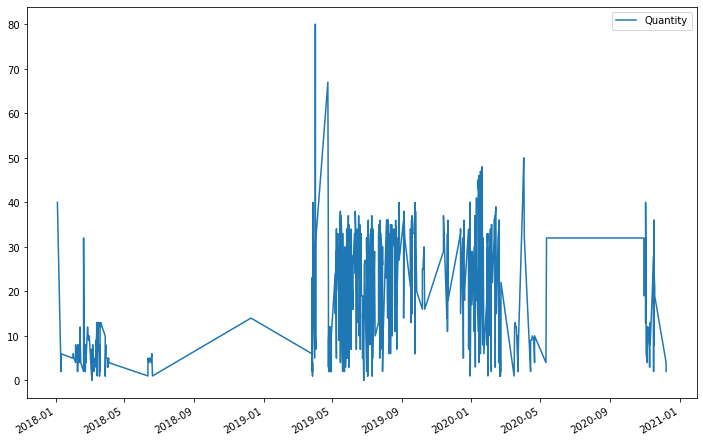

In [84]:
final_df[['Quantity','forecast']].plot(figsize=(12,8))